### Cellule 1 — Imports & chargement

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
classification_report
)
import matplotlib.pyplot as plt
import joblib


# Chargement
df = pd.read_csv("data/emails.csv")
df = df.dropna(subset=["text", "label"]).copy()
X = df["text"].astype(str)
y = (df["label"].str.lower() == "spam").astype(int) # 1=spam, 0=ham


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


### Cellule 2 — Baseline : Logistic Regression

In [3]:
baseline = Pipeline([
("tfidf", TfidfVectorizer(min_df=2, ngram_range=(1,2))),
("clf", LogisticRegression(max_iter=200, n_jobs=None))
])


baseline.fit(X_train, y_train)
proba = None
try:
    proba = baseline.predict_proba(X_test)[:,1]
except Exception:
    proba = None


pred = baseline.predict(X_test)


metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "precision": precision_score(y_test, pred, zero_division=0),
    "recall": recall_score(y_test, pred, zero_division=0),
    "f1": f1_score(y_test, pred, zero_division=0),
}

if proba is not None:
    try:
        metrics["roc_auc"] = roc_auc_score(y_test, proba)
    except Exception:
        pass
    metrics

### Cellule 4 — Courbes ROC et Precision‑Recall (LogReg)

[[966   0]
 [ 33 116]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



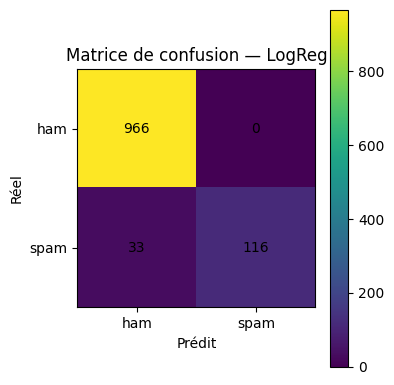

Faux positifs (ham→spam) : 0


In [4]:
cm = confusion_matrix(y_test, pred)
print(cm)
print(classification_report(y_test, pred, target_names=["ham","spam"]))


# Graphique : matrice de confusion
fig = plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Matrice de confusion — LogReg')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["ham","spam"])
plt.yticks(tick_marks, ["ham","spam"])
plt.xlabel('Prédit')
plt.ylabel('Réel')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.tight_layout()
plt.show()


fp = cm[0,1]
print(f"Faux positifs (ham→spam) : {fp}")

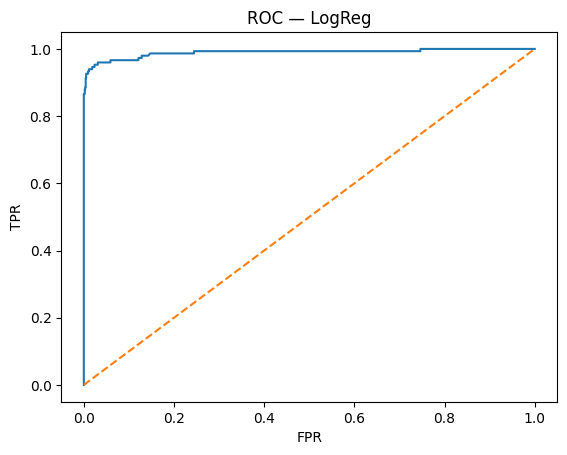

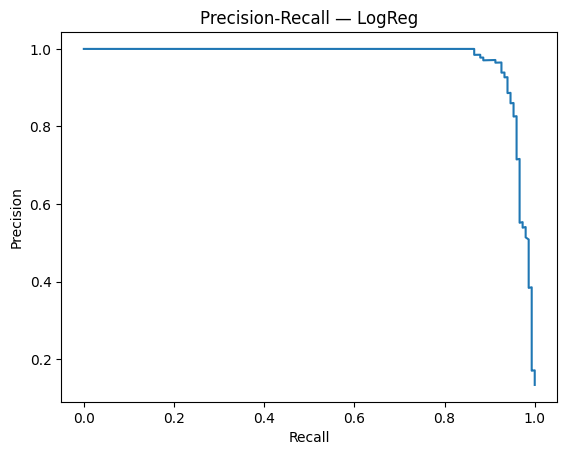

In [5]:
if proba is not None:
    fpr, tpr, _ = roc_curve(y_test, proba)
    fig = plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC — LogReg')
    plt.show()


    prec, rec, _ = precision_recall_curve(y_test, proba)
    fig = plt.figure()
    plt.plot(rec, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision‑Recall — LogReg')
    plt.show()

### Cellule 5 — Comparaison multi‑modèles

In [6]:
models = {
    "LogReg": LogisticRegression(max_iter=200),
    "LinearSVC": LinearSVC(),
    "SVM_rbf": SVC(kernel='rbf', probability=True),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    # "XGBoost": xgb.XGBClassifier(eval_metric='logloss')  # si installé
}

results = []
roc_curves = {}
pr_curves = {}

for name, clf in models.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(min_df=2, ngram_range=(1,2))),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    row = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_hat),
        "precision": precision_score(y_test, y_hat, zero_division=0),
        "recall": recall_score(y_test, y_hat, zero_division=0),
        "f1": f1_score(y_test, y_hat, zero_division=0)
    }
    # proba si dispo
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
        row["roc_auc"] = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[name] = (fpr, tpr)
        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        pr_curves[name] = (rec, prec)
    except Exception:
        pass

    results.append(row)

    # garder le meilleur pour sauvegarde ultérieure
    if name == "LogReg":
        best_pipeline = pipe

pd.DataFrame(results).sort_values(by=["f1","accuracy"], ascending=False)

,model,accuracy,precision,recall,f1,roc_auc
1,LinearSVC,0.985650,0.985401,0.906040,0.944056,NaN
2,SVM_rbf,0.980269,0.992248,0.859060,0.920863,0.988571
4,RandomForest,0.971300,1.000000,0.785235,0.879699,0.993747
0,LogReg,0.970404,1.000000,0.778523,0.875472,0.989447
3,MultinomialNB,0.959641,1.000000,0.697987,0.822134,0.976614


### Cellule 6 — Graphiques comparatifs (ROC/PR)

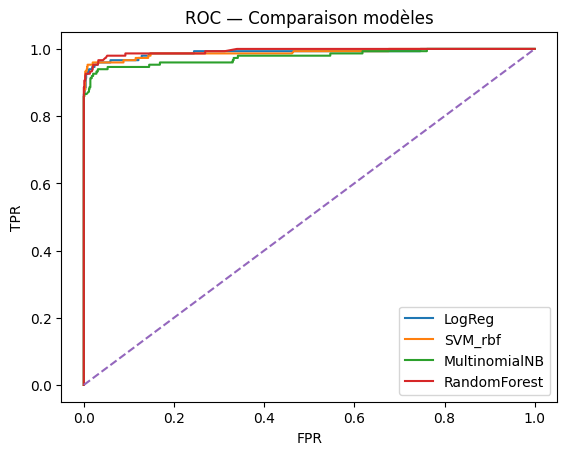

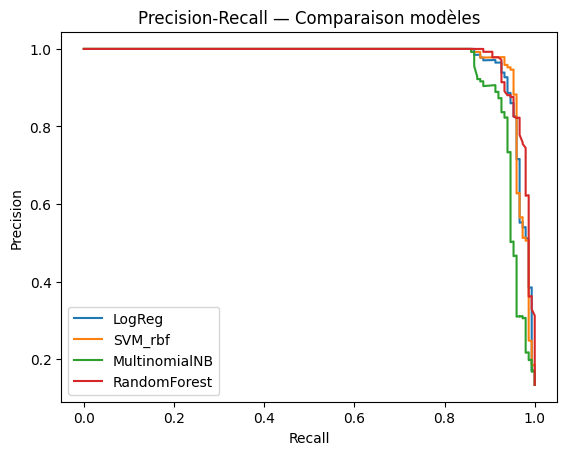

In [8]:
# ROC
if roc_curves:
    fig = plt.figure()
    for name, (fpr, tpr) in roc_curves.items():
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC — Comparaison modèles')
    plt.legend()
    plt.show()

# PR
if pr_curves:
    fig = plt.figure()
    for name, (rec, prec) in pr_curves.items():
        plt.plot(rec, prec, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision‑Recall — Comparaison modèles')
    plt.legend()
    plt.show()

### Cellule 7 — Importance des features (LogReg)


In [9]:
# Top poids de la régression logistique
vec = best_pipeline.named_steps["tfidf"]
clf = best_pipeline.named_steps["clf"]
if hasattr(clf, "coef_"):
    terms = np.array(vec.get_feature_names_out())
    coefs = clf.coef_[0]
    top_spam_idx = np.argsort(coefs)[-20:][::-1]
    top_ham_idx = np.argsort(coefs)[:20]
    print("Top mots → spam:")
    print(list(zip(terms[top_spam_idx], coefs[top_spam_idx])))
    print("\nTop mots → ham:")
    print(list(zip(terms[top_ham_idx], coefs[top_ham_idx])))

Top mots → spam:
[('call', np.float64(4.327524920360467)), ('txt', np.float64(4.171523456682995)), ('free', np.float64(3.5694167015338367)), ('to', np.float64(3.187111805249182)), ('text', np.float64(2.968290879971911)), ('reply', np.float64(2.9436123360827784)), ('stop', np.float64(2.7758850709974054)), ('www', np.float64(2.7438809550432977)), ('uk', np.float64(2.742176304250034)), ('claim', np.float64(2.6777589441591987)), ('mobile', np.float64(2.623263750004161)), ('your', np.float64(2.4648091027189785)), ('150p', np.float64(2.2931025146071846)), ('from', np.float64(2.26477713246403)), ('service', np.float64(2.1905719814042146)), ('com', np.float64(2.1266609706555406)), ('prize', np.float64(2.0310676949218998)), ('you have', np.float64(1.9841107193903713)), ('win', np.float64(1.9318719072077462)), ('now', np.float64(1.8972209058455156))]

Top mots → ham:
[('my', np.float64(-2.27357065951644)), ('me', np.float64(-2.1256699064937012)), ('that', np.float64(-1.6410315176324028)), ('ok',

### Cellule 8 — Sauvegarde du modèle baseline

In [10]:
Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(best_pipeline, "models/model.pkl")
print("Saved models/model.pkl")

Saved models/model.pkl
